In [34]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from advi_jax.variational_distributions import MeanField
from advi_jax import ADVI
from advi_jax.metrics import kl_divergence
from advi_jax.init import initialize
import tensorflow_probability.substrates.jax as tfp
import distrax
import optax
import jaxopt
from time import time

rc('animation', html='jshtml')
dist = tfp.distributions

In [35]:
import logging
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger = logging.getLogger("root")
logger.addFilter(CheckTypesFilter())

## Linear regression

### Useful functions

In [36]:
def pair_wise_prior(f):
    f = jax.vmap(f, in_axes=(None, 0))
    f = jax.vmap(f, in_axes=(0, None))
    return f

def pair_wise_likelihood(f):
    f = jax.vmap(f, in_axes=(None, 0))
    f = jax.vmap(f, in_axes=(0, None))
    return f

def plot_prior_lik_post(data, prior_dist, params, posterior_dist=None):
    fig, ax = plt.subplots(1,3,figsize=(12,3))
    X, y, noise = data
    w_0_range = jnp.linspace(-5.0, 5.0, 100)
    w_1_range = jnp.linspace(-5.0, 5.0, 100)
    W0, W1 = jnp.meshgrid(w_0_range, w_1_range)
    
    prior_probs = pair_wise_prior(lambda x, y: prior_dist.prob(jnp.array([x, y])))(w_0_range, w_1_range)
    likelihood_probs = pair_wise_likelihood(lambda x, y: likelihood_log_prob_fun(jnp.array([x, y]), data, **params))(w_0_range, w_1_range)

    names = ["prior", "likelihood"]
    values = [prior_probs, likelihood_probs]
    
    if "variational_dist" in params:
        posterior_probs = pair_wise_prior(lambda x, y: params["variational_dist"].prob(jnp.array([x, y])))(w_0_range, w_1_range)
        names.append("posterior")
        print(posterior_probs.shape)
        values.append(posterior_probs)
        
    ax[0].set_ylabel("$w_1$")
    for i, value in enumerate(values):
        obj = ax[i].contourf(W0, W1, value, levels=20)
        ax[i].set_aspect("equal")
        fig.colorbar(obj, ax=ax[i])
        ax[i].set_title(names[i])
        ax[i].set_xlabel("$w_0$")
        
    # Plot fit
    plt.figure()
    plt.scatter(X[:, 1], y, label="data")
    true_mean = (X@w_true).flatten()
    true_std = (jnp.ones_like(true_mean) * noise).flatten()
    plt.plot(X[:, 1], true_mean, label="true mean")
    
    # plot true posterior
    true_post_var = jnp.linalg.inv((X.T@X)/(noise**2) + jnp.diag(1/prior_dist.scale.diag))
    true_post_mean = true_post_var@(X.T@y.reshape(-1,1)/(noise**2) + jnp.diag(1/prior_dist.scale.diag)@prior_dist.loc.reshape(-1,1))
    
    print(f"True posterior: mean: {true_post_mean.ravel()}, scale: {true_post_var.ravel()}")
    
    y_true_post_mean = (X@true_post_mean).flatten()
    y_true_post_std = ((jnp.diag(X@true_post_var@X.T) + noise**2) ** 0.5).flatten()
    plt.plot(X[:,1], y_true_post_mean, label="true post mean")
    plt.fill_between(X[:,1], y_true_post_mean - 2 * y_true_post_std, y_true_post_mean + 2 * y_true_post_std, label="true post mean", alpha=0.2)
    
    # plot variational posterior
    if "variational_dist" in params:
        y_post_mean = (X@params["variational_dist"].u_mean.reshape(-1,1)).flatten()
        y_post_std = ((jnp.diag(X@jnp.diag(jnp.exp(params["variational_dist"].u_scale))@X.T) + noise**2) ** 0.5).flatten()
        plt.plot(X[:,1], y_post_mean, label="post mean")
        plt.fill_between(X[:,1], y_post_mean - 2 * y_post_std, y_post_mean + 2 * y_post_std, label="post mean", alpha=0.2)
    plt.legend()
    
def likelihood_fun(sample, X, noise, **params):
    mean = (X@sample.reshape(-1,1)).flatten()
    scale = jnp.ones(shape=(X.shape[0], )) * noise
    return dist.MultivariateNormalDiag(mean, scale)

def likelihood_log_prob_fun(sample, data, **params):
    X, y, noise = data
    likelihood = likelihood_fun(sample, X, noise, **params)
    print(X.shape, y.shape)
    return likelihood.log_prob(y)

def inference_loop(key, params, model, optimizer, n_iterations, n_samples):
    def one_step(carry, key):
        params, state, data = carry
        value, grads = model.value_and_grad_fun(key, params, data, n_samples)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state, data), value

#     keys = jax.random.split(key, n_iterations)
    keys = jnp.array([jax.random.split(key, 1)[0]] * n_iterations)
    print(keys.shape)
    state = optimizer.init(params)
    carry = (params, state, model.data)
    one_step = jax.jit(one_step, static_argnums=2)
    (params, state, data), values = jax.lax.scan(one_step, carry, keys)

    return values, params

def inference_loop_jaxopt(key, params, model, optimizer, n_iterations, n_samples):
    def one_step(carry, key):
        params, state, data = carry
        value, grads = model.value_and_grad_fun(key, params, data, n_samples)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state, data), value

    key = jax.random.split(key, 1)[0]
    jaxopt.ScipyMinimize()
    state = optimizer.init(params)
    carry = (params, state, model.data)
    one_step = jax.jit(one_step, static_argnums=2)
    (params, state, data), values = jax.lax.scan(one_step, carry, keys)

    return values, params

### Simulate data

(10, 2) (10,)
True posterior: mean: [0.8958941 1.7534482], scale: [0.02439024 0.         0.         0.05781584]


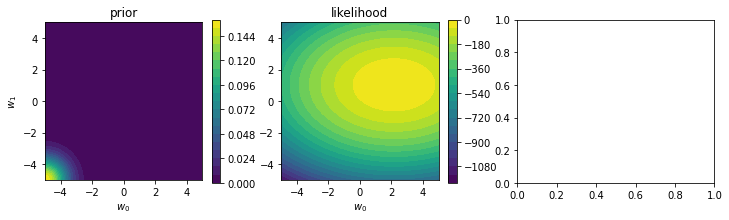

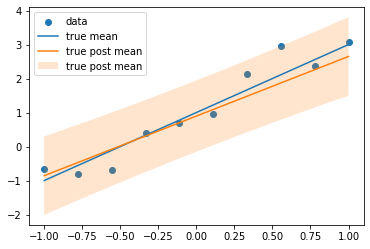

In [39]:
key = jax.random.PRNGKey(1)
prior_dist = distrax.MultivariateNormalDiag(loc=jnp.array([-5.0, -5.0]), scale_diag=jnp.array([1.0, 1.0]))
w_true = jnp.array([1.0, 2.0]).reshape(-1,1)
noise_scale = jnp.array(0.5)

X = jnp.linspace(-1, 1, 10).reshape(-1,1)
X = jnp.concatenate([jnp.ones_like(X), X], axis=1)
y = X@w_true + jax.random.normal(key, shape=(X.shape[0], 1)) * noise_scale
y = y.flatten()
data = (X, y, noise_scale)

plot_prior_lik_post(data, prior_dist, {})

### Model definition

In [40]:
model = ADVI(prior_dist, likelihood_log_prob_fun, data)

u_mean = jnp.array([0.1, 0.2])
u_scale = jnp.array([0.1, 0.2])
variational_dist = MeanField(u_mean, u_scale)

### Training

initial params {'variational_dist': MeanField(mean=[0.1 0.2], scale=[1.105171  1.2214028])}
(100, 2)
Variational dist: (2,)
(10, 2) (10,)
final params MeanField(mean=[0.89946705 1.7323965 ], scale=[0.11930325 0.18920586])
0.49 seconds


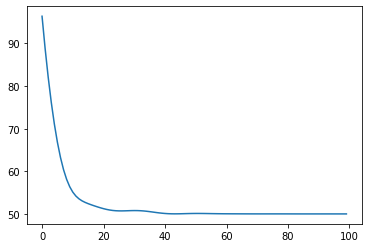

In [41]:
seed = 2
key = jax.random.PRNGKey(seed)
subkey = jax.random.PRNGKey(seed+1)

n_samples = 100
n_iterations=100
learning_rate = 0.1

t_init = time()

params = {"variational_dist": variational_dist}
# params = initialize(key, params)  # randomly initialize the parameters
print("initial params", params)
optimizer = optax.adam(learning_rate=0.1)
losses, params = inference_loop(subkey, params, model, optimizer, n_iterations, n_samples)
print("final params", params["variational_dist"])
print(f"{time()-t_init:.2f} seconds")
plt.plot(losses);

(10, 2) (10,)
(100, 100)
True posterior: mean: [0.8958941 1.7534482], scale: [0.02439024 0.         0.         0.05781584]


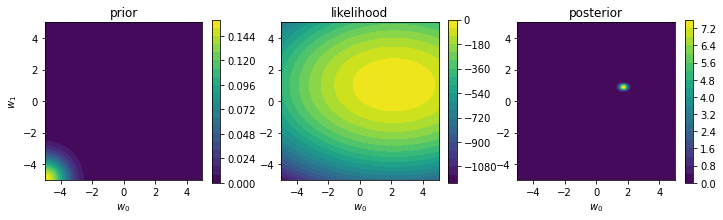

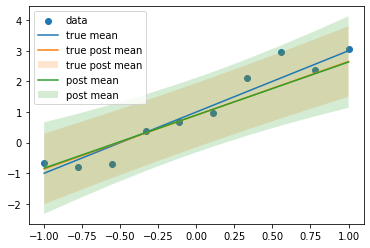

In [42]:
plot_prior_lik_post(data, prior_dist, params)

### Interactive demo

In [8]:
# from ipywidgets import interact

In [9]:
# @interact(w0=(0.1, 10.0), w1=(0.1, 10.0), a=(0.1, 100.0), b=(0.1, 100.0), seed=(0, 10), n_iterations=(1,1000), n_samples=(1,1000))
# def plot_vi(n_heads=jnp.sum(data), n_tails=len(data) - jnp.sum(data), a=prior_dist.concentration1, b=prior_dist.concentration0, seed=seed, n_iterations=n_iterations, n_samples=n_samples):
#     key = jax.random.PRNGKey(seed)
#     subkey = jax.random.PRNGKey(seed+1)
    
#     data = jnp.array([1]*n_heads + [0]*n_tails)
#     prior_dist = dist.Beta(a, b)
    
#     model = ADVI(prior_dist, likelihood_log_prob_fun, data)
#     variational_dist = MeanField(bijector=distrax.Sigmoid())
    
#     params = {"variational_dist": variational_dist}
#     params = initialize(key, params)
#     print("initial params", params["variational_dist"])
#     optimizer = optax.adam(learning_rate=0.1)
#     losses, params = inference_loop(subkey, params, model, optimizer, n_iterations, n_samples)
#     print("final params", params["variational_dist"])
    
# #     plt.plot(losses)
#     plot_prior_lik_post(data, prior_dist, posterior_dist=params["variational_dist"])